In [1]:
from google.colab import files
uploaded = files.upload()

Saving listingsDallas.csv to listingsDallas.csv
Saving reviewsDallas.csv to reviewsDallas.csv


In [2]:
import pandas as pd
from sklearn.utils import resample
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from bs4 import BeautifulSoup
import re

listings = pd.read_csv(io.BytesIO(uploaded['listingsDallas.csv']))
reviews = pd.read_csv(io.BytesIO(uploaded['reviewsDallas.csv']))

# Data Cleaning

Checking all the attributes in the daatset


In [3]:
print(listings.columns)
print(reviews.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

Removing unnecessary attributes from the daatset

In [4]:
#Before Dropping
print(listings.shape)

listings = listings.drop(['listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'calendar_updated','license','calendar_last_scraped'], axis=1)

#After dropping
print(listings.shape)

(5220, 75)
(5220, 59)


Price column has \$ symbol and cannot be processed as a numerical column. So, removing the \$ sign and converting it to float

In [5]:
# Ensure that the 'price' column is treated as a string first
listings['price'] = listings['price'].astype(str)

# Remove the $ symbol and commas using regex, then convert to numeric
listings['price'] = listings['price'].str.replace(r'[$,]', '', regex=True)

# Convert the cleaned 'price' column to a numeric type
listings['price'] = pd.to_numeric(listings['price'], errors='coerce')

# Check the result
print(listings['price'].head())
print(listings['price'].dtype)

0     85.0
1     65.0
2    243.0
3     62.0
4     54.0
Name: price, dtype: float64
float64


Checking if any of the numerical attributes have string or text data

In [6]:
# Convert the specified columns to numeric, coerce errors to NaN
cols_to_check = ['price','minimum_nights','maximum_nights','number_of_reviews','bedrooms', 'bathrooms', 'beds', 'accommodates',
                 'availability_30', 'availability_365', 'number_of_reviews_ltm','review_scores_rating']

# Function to check if values are non-numeric
def count_non_numeric(series):
    # This will return True for non-numeric values (strings or text)
    return series.apply(pd.to_numeric, errors='coerce').isna().sum()

# Apply the function to each column and get the count of non-numeric rows per column
non_numeric_counts = listings[cols_to_check].apply(count_non_numeric)

# Output the result
print("Number of rows with non-numeric values for each column:")
print(non_numeric_counts)



Number of rows with non-numeric values for each column:
price                    212
minimum_nights             0
maximum_nights             0
number_of_reviews          0
bedrooms                  36
bathrooms                214
beds                     219
accommodates               0
availability_30            0
availability_365           0
number_of_reviews_ltm      0
review_scores_rating     828
dtype: int64


Cleaning the text attributes room_type

In [7]:
# Remove leading/trailing spaces
listings['room_type'] = listings['room_type'].str.strip()

# Standardize text to lowercase
listings['room_type'] = listings['room_type'].str.lower()


Checking for missing values in the text attributes room_type and neighbourhood_cleansed

In [8]:
import pandas as pd

# Specify the columns to check for missing values
columns_to_check = ['room_type', 'neighbourhood_cleansed']

# Get the count of missing values for the specified columns
missing_values = listings[columns_to_check].isnull().sum()

# Display the number of missing values for these columns
print(missing_values)


room_type                 0
neighbourhood_cleansed    0
dtype: int64


Converting the amenities in each row into a numerical attribute in order to be used for further analysis.

In [9]:
# Function to clean and count the number of amenities in each record
def count_amenities(amenities_str):
    # Decode special characters and remove unnecessary characters like quotes, square brackets, etc.
    cleaned_amenities_str = amenities_str.encode('utf-8').decode('unicode_escape').strip('[]').replace('"', '')

    # Split the cleaned string into a list of amenities
    amenities_list = cleaned_amenities_str.split(', ')

    # Return the count of amenities
    return len(amenities_list)

# Apply the function to each record in the 'amenities' column
listings['amenities_count'] = listings['amenities'].apply(lambda x: count_amenities(x))

# Display the updated DataFrame with the new column
print(listings[['amenities', 'amenities_count']])

                                              amenities  amenities_count
0     ["Smoke alarm", "Keypad", "Shampoo", "Pets all...               24
1     ["Extra pillows and blankets", "Clothing stora...               44
2     ["Extra pillows and blankets", "Smoke alarm", ...               74
3     ["Smoke alarm", "Essentials", "Free parking on...               18
4     ["Smoke alarm", "Refrigerator", "Dishwasher", ...               35
...                                                 ...              ...
5215  ["Extra pillows and blankets", "Smoke alarm", ...               32
5216  ["Extra pillows and blankets", "Smoke alarm", ...               32
5217  ["Smoke alarm", "Exterior security cameras on ...                8
5218  ["Extra pillows and blankets", "Smoke alarm", ...               50
5219  ["Extra pillows and blankets", "Smoke alarm", ...               45

[5220 rows x 2 columns]


# Descriptive Statistics

Calculate summary statistics for numerical features such as `price`,
`minimum_nights`, `maximum_nights`, `number_of_reviews`, and
`review_scores_rating`. Understand the central tendency, dispersion, and
distribution of these variables.

In [10]:
# List of numerical features to analyze
numerical_features = ['price','minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating']

# Additional features for analysis
additional_numerical_features = ['accommodates','availability_30', 'availability_365', 'number_of_reviews_ltm']

Removing null values from the required numerical features

In [11]:
# Convert columns to numeric, invalid parsing will be set as NaN
listings[numerical_features] = listings[numerical_features].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns (i.e., non-numeric values)
listings_1 = listings.dropna(subset=numerical_features)

# Check the DataFrame to ensure non-numeric values have been removed
print(listings_1)

# Verify that all specified columns are numerical
print(listings_1[numerical_features].dtypes)

                       id                                               name  \
0                   61878                      MODERN LIVING AND FURNISHINGS   
1                  270936   1BR 1BA Oaklawn Condo Close to Downtown & Uptown   
2                  795703           Amazing location walk to Downtown Dallas   
3                  826118                      Far North Dallas -- Blue Room   
4                  826201                      Far North Dallas -- Gray Room   
...                   ...                                                ...   
5136  1217763160952849055  Marvelous 2Bd1Bath Gsthouse 5min 2 Zoo| 2 King...   
5165  1219967954403333632  Dallas Urban Oasis | 2 BR | Pool View | Prime ...   
5185  1222404461603617038               1 Bedroom + 1 Bath + Downtown Dallas   
5190  1222533291335582338                                             Room 3   
5196  1222729134348740229     Urban Oasis in DownTown Dallas| 1BR Luxury Apt   

                                       

Calculating the summary statistics for the required numerical values

In [12]:
def display_summary_statistics(dataframe, numerical_features):
    # Calculate summary statistics
    summary_statistics = dataframe[numerical_features].describe()

    # Display the summary statistics
    print("Summary Statistics:")
    print(summary_statistics)

numerical_features = ['price', 'minimum_nights','maximum_nights', 'review_scores_rating']
display_summary_statistics(listings_1, numerical_features)


Summary Statistics:
              price  minimum_nights  maximum_nights  review_scores_rating
count   4229.000000     4229.000000     4229.000000           4229.000000
mean     188.987231        7.595649      515.995744              4.737122
std      574.118700       17.761511      390.517836              0.424237
min        6.000000        1.000000        1.000000              1.000000
25%       79.000000        1.000000      365.000000              4.670000
50%      112.000000        2.000000      365.000000              4.860000
75%      178.000000        3.000000     1125.000000              5.000000
max    10000.000000      500.000000     1125.000000              5.000000


Removing null values from the additional numerical features

In [13]:
# Convert columns to numeric, invalid parsing will be set as NaN
listings[additional_numerical_features] = listings[additional_numerical_features].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns (i.e., non-numeric values)
listings_2 = listings.dropna(subset=additional_numerical_features)

# Check the DataFrame to ensure non-numeric values have been removed
print(listings_2)

# Verify that all specified columns are numerical
print(listings_2[additional_numerical_features].dtypes)

                       id                                               name  \
0                   61878                      MODERN LIVING AND FURNISHINGS   
1                  270936   1BR 1BA Oaklawn Condo Close to Downtown & Uptown   
2                  795703           Amazing location walk to Downtown Dallas   
3                  826118                      Far North Dallas -- Blue Room   
4                  826201                      Far North Dallas -- Gray Room   
...                   ...                                                ...   
5215  1224252669864420807                         Stunning 1BR Uptown Dallas   
5216  1224260018780481012                         Gorgeous 1BR Uptown Dallas   
5217  1224318970301433680                    Master Bedroom(2) near downtown   
5218  1224398152252300429       Spacious 2-Bedroom Apartment in Dallas Texas   
5219  1225230832554382606  Quiet Remodeled 1BR King Suite | Pool, Gym, Pa...   

                                       

Calculating the summary statistics for the additional numerical features

In [30]:
display_summary_statistics(listings_2, additional_numerical_features)

Summary Statistics:
       accommodates  availability_30  availability_365  number_of_reviews_ltm
count   5220.000000      5220.000000       5220.000000            5220.000000
mean       5.066858        18.252299        235.581034              13.504598
std        3.535809        10.952131        118.411035              19.962347
min        1.000000         0.000000          0.000000               0.000000
25%        2.000000         9.000000        136.000000               1.000000
50%        4.000000        22.000000        265.000000               5.000000
75%        6.000000        29.000000        351.000000              19.000000
max       16.000000        30.000000        365.000000             249.000000


Calculating the values variance, skewness, kurtosis for understanding the central tendency, dispersion

In [15]:
# Calculate variance
variance_values1 = listings_1[numerical_features].var()
variance_values2 = listings_2[additional_numerical_features].var()
print("\nVariance Values:")
print(variance_values1)
print(variance_values2)

# Calculate skewness
skewness_values1 = listings_1[numerical_features].skew()
skewness_values2 = listings_2[additional_numerical_features].skew()
print("\nSkewness Values:")
print(skewness_values1)
print(skewness_values2)

# Calculate kurtosis
kurtosis_values1 = listings_1[numerical_features].kurt()
kurtosis_values2 = listings_2[additional_numerical_features].kurt()
print("\nKurtosis Values:")
print(kurtosis_values1)
print(kurtosis_values2)


Variance Values:
price                   329612.282240
minimum_nights             315.471277
maximum_nights          152504.180209
review_scores_rating         0.179977
dtype: float64
accommodates                12.501948
availability_30            119.949171
availability_365         14021.173160
number_of_reviews_ltm      398.495284
dtype: float64

Skewness Values:
price                   15.630988
minimum_nights           9.655929
maximum_nights           0.660896
review_scores_rating    -4.441637
dtype: float64
accommodates             1.397622
availability_30         -0.558873
availability_365        -0.527205
number_of_reviews_ltm    2.912825
dtype: float64

Kurtosis Values:
price                   261.271790
minimum_nights          191.726469
maximum_nights           -1.047409
review_scores_rating     28.330805
dtype: float64
accommodates              1.594649
availability_30          -1.151676
availability_365         -1.077416
number_of_reviews_ltm    14.564664
dtype: float64


# 2. Distribution Analysis

Plot histograms or density plots for key numerical features like price,minimum_nights, and review_scores_rating. Analyze the distribution of these features to identify any skewness or outliers.

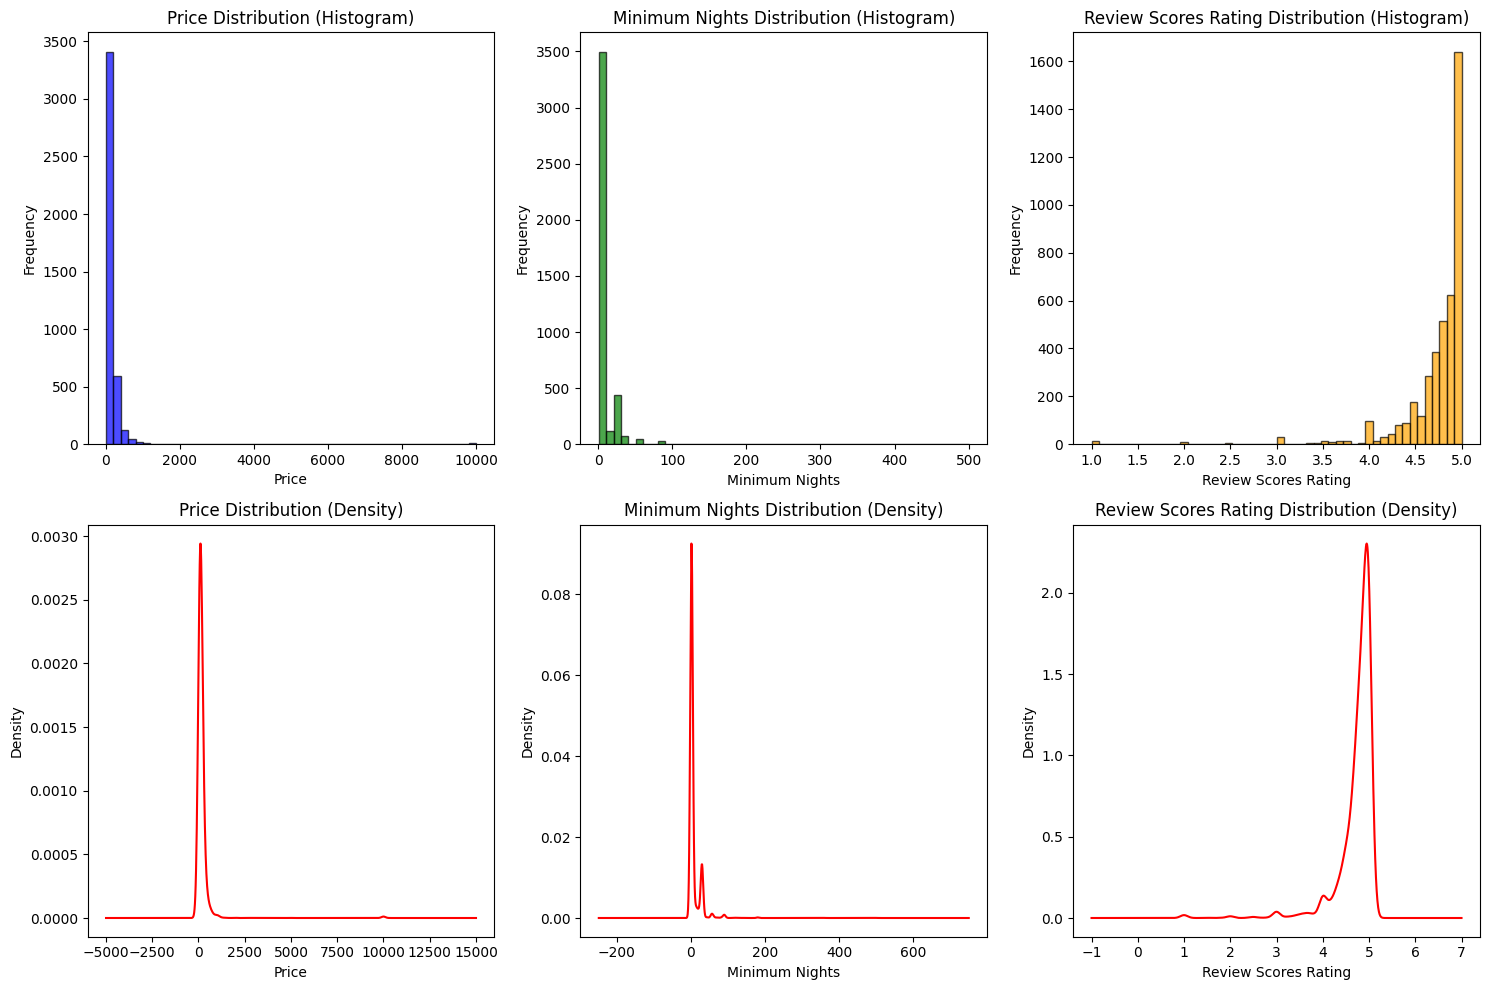

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_numerical_distributions(dataframe):
    """
    Plot histograms and density plots for key numerical features in the DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the numerical features.
    """
    plt.figure(figsize=(15, 10))

    # Price histogram
    plt.subplot(2, 3, 1)
    plt.hist(dataframe['price'], bins=50, color='blue', edgecolor='black', alpha=0.7)
    plt.title('Price Distribution (Histogram)')
    plt.xlabel('Price')
    plt.ylabel('Frequency')

    # Price density plot
    plt.subplot(2, 3, 4)
    dataframe['price'].plot(kind='kde', color='red')
    plt.title('Price Distribution (Density)')
    plt.xlabel('Price')
    plt.ylabel('Density')

    # Minimum nights histogram
    plt.subplot(2, 3, 2)
    plt.hist(dataframe['minimum_nights'], bins=50, color='green', edgecolor='black', alpha=0.7)
    plt.title('Minimum Nights Distribution (Histogram)')
    plt.xlabel('Minimum Nights')
    plt.ylabel('Frequency')

    # Minimum nights density plot
    plt.subplot(2, 3, 5)
    dataframe['minimum_nights'].plot(kind='kde', color='red')
    plt.title('Minimum Nights Distribution (Density)')
    plt.xlabel('Minimum Nights')
    plt.ylabel('Density')

    # Review scores rating histogram
    plt.subplot(2, 3, 3)
    plt.hist(dataframe['review_scores_rating'].dropna(), bins=50, color='orange', edgecolor='black', alpha=0.7)
    plt.title('Review Scores Rating Distribution (Histogram)')
    plt.xlabel('Review Scores Rating')
    plt.ylabel('Frequency')

    # Review scores rating density plot
    plt.subplot(2, 3, 6)
    dataframe['review_scores_rating'].dropna().plot(kind='kde', color='red')
    plt.title('Review Scores Rating Distribution (Density)')
    plt.xlabel('Review Scores Rating')
    plt.ylabel('Density')

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_numerical_distributions(listings_1)


# 3. Correlation Analysis

Create a correlation matrix to explore relationships between numerical variables such as price, number_of_reviews, availability_365, and review_scores_rating. Identify any strong correlations that might be useful for predictive modeling or further investigation.

Plotting correlation matrix and heatmap for the required attributes

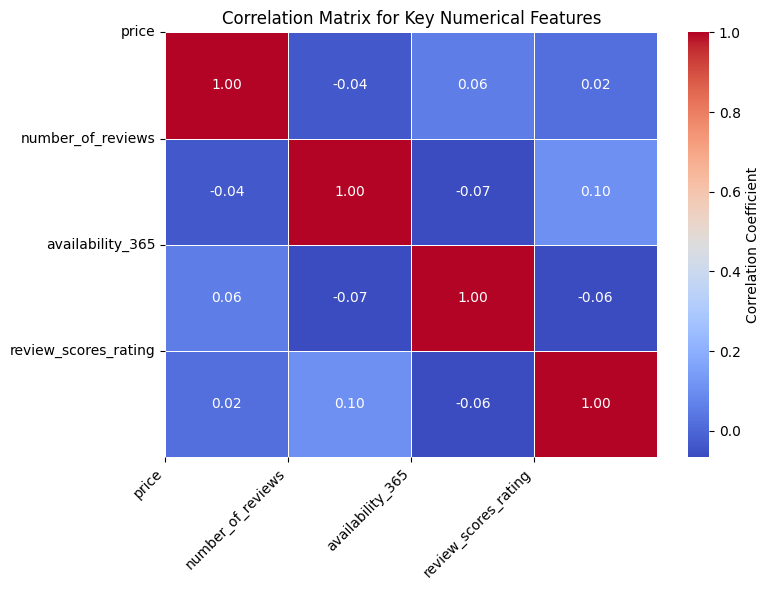

,price,number_of_reviews,availability_365,review_scores_rating
price,1.000000,-0.035144,0.055724,0.020612
number_of_reviews,-0.035144,1.000000,-0.066293,0.104593
availability_365,0.055724,-0.066293,1.000000,-0.063807
review_scores_rating,0.020612,0.104593,-0.063807,1.000000


In [17]:
#List of columns
correlation_columns = ['price', 'number_of_reviews', 'availability_365', 'review_scores_rating']

# Convert columns to numeric, invalid parsing will be set as NaN
listings[correlation_columns] = listings[correlation_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns
listings_3 = listings_1.dropna(subset=correlation_columns)

# Creating the correlation matrix
correlation_matrix = listings_3[correlation_columns].corr()

# Plotting the correlation matrix using a heatmap with annotations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})

# Formatting the heatmap
plt.xticks(range(len(correlation_columns)), correlation_columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_columns)), correlation_columns)
plt.title('Correlation Matrix for Key Numerical Features')

# Show the plot
plt.tight_layout()
plt.show()

# Displaying the correlation matrix
correlation_matrix

Plotting correlation matrix and heatmap for additional attributes

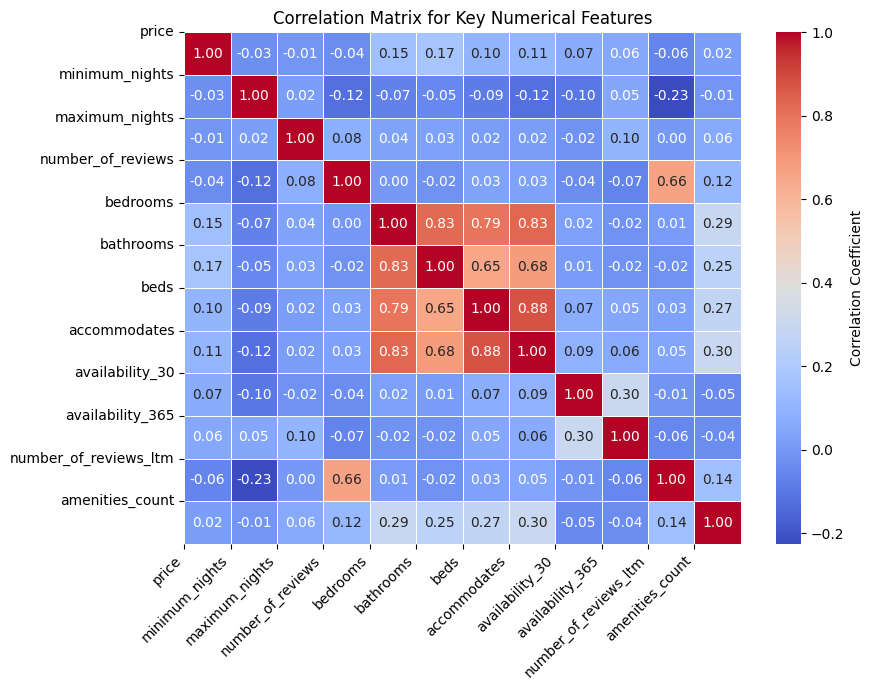

,price,minimum_nights,maximum_nights,number_of_reviews,bedrooms,bathrooms,beds,accommodates,availability_30,availability_365,number_of_reviews_ltm,amenities_count
price,1.000000,-0.033122,-0.007157,-0.035181,0.146041,0.169599,0.103035,0.105350,0.068243,0.055926,-0.058008,0.020619
minimum_nights,-0.033122,1.000000,0.022571,-0.122190,-0.071745,-0.052958,-0.087014,-0.121801,-0.098436,0.049302,-0.225452,-0.006312
maximum_nights,-0.007157,0.022571,1.000000,0.079224,0.036996,0.030107,0.015220,0.015944,-0.023358,0.100711,0.002352,0.057849
number_of_reviews,-0.035181,-0.122190,0.079224,1.000000,0.000800,-0.017729,0.033086,0.031180,-0.036663,-0.066617,0.662840,0.118631
bedrooms,0.146041,-0.071745,0.036996,0.000800,1.000000,0.826741,0.794912,0.829100,0.023479,-0.015989,0.009459,0.291949
bathrooms,0.169599,-0.052958,0.030107,-0.017729,0.826741,1.000000,0.652665,0.684414,0.010240,-0.023646,-0.015342,0.252037
beds,0.103035,-0.087014,0.015220,0.033086,0.794912,0.652665,1.000000,0.877896,0.072999,0.048239,0.028321,0.269268
accommodates,0.105350,-0.121801,0.015944,0.031180,0.829100,0.684414,0.877896,1.000000,0.091975,0.062647,0.046297,0.296665
availability_30,0.068243,-0.098436,-0.023358,-0.036663,0.023479,0.010240,0.072999,0.091975,1.000000,0.301256,-0.011611,-0.047781
availability_365,0.055926,0.049302,0.100711,-0.066617,-0.015989,-0.023646,0.048239,0.062647,0.301256,1.000000,-0.055106,-0.038686


In [18]:
#List of columns
correlation_columns = ['price','minimum_nights','maximum_nights','number_of_reviews','bedrooms','bathrooms','beds','accommodates','availability_30','availability_365','number_of_reviews_ltm','amenities_count']

# Convert columns to numeric, invalid parsing will be set as NaN
listings[correlation_columns] = listings[correlation_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows that have NaN in any of the specified columns
listings_4 = listings_1.dropna(subset=correlation_columns)

# Creating the correlation matrix
correlation_matrix = listings_4[correlation_columns].corr()

# Plotting the correlation matrix using a heatmap with annotations
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})

# Formatting the heatmap
plt.xticks(range(len(correlation_columns)), correlation_columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_columns)), correlation_columns)
plt.title('Correlation Matrix for Key Numerical Features')

# Show the plot
plt.tight_layout()
plt.show()

# Displaying the correlation matrix
correlation_matrix


# 4. Price Analysis

Analyze the distribution of prices across different neighborhoods (host_neighbourhood) or room types (if available). Understand which neighborhoods have higher or lower average prices and whether certain neighborhoods are more popular for shortterm or longterm stays.

In [19]:
listings['stay_type'] = listings['minimum_nights'].apply(lambda x: 'Long-term' if x > 30 else 'Short-term')

# Extracting relevant columns for price analysis: price, neighbourhood_cleansed, room_type, and minimum_nights
price_analysis_columns = ['price', 'neighbourhood_cleansed', 'room_type', 'minimum_nights', 'maximum_nights', 'stay_type']

# Creating the price_analysis_data DataFrame
price_analysis_data = listings[price_analysis_columns].dropna()

# Calculating average price per neighborhood
avg_price_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['price'].mean().sort_values(ascending=False)

# Calculating average minimum/maximum nights per neighborhood (to understand short-term vs long-term stays)
avg_minimum_nights_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['minimum_nights'].mean().sort_values(ascending=False)
avg_maximum_nights_neighbourhood = price_analysis_data.groupby('neighbourhood_cleansed')['maximum_nights'].mean().sort_values(ascending=False)

# Calculating average price per room type
avg_price_room_type = price_analysis_data.groupby('room_type')['price'].mean().sort_values(ascending=False)

# Calculate average price for short-term and long-term stays by neighborhood
avg_price_neighbourhood_stay_type = price_analysis_data.groupby(['neighbourhood_cleansed', 'stay_type'])['price'].mean().unstack().fillna(0)

# Calculate average price for short-term and long-term stays by room type
avg_price_room_type_stay_type = price_analysis_data.groupby(['room_type', 'stay_type'])['price'].mean().unstack().fillna(0)

# Displaying the results
print("Average Price by Neighborhood:")
print(avg_price_neighbourhood)

print("\nAverage Minimum Nights by Neighborhood:")
print(avg_minimum_nights_neighbourhood)

print("\nAverage Maximum Nights by Neighborhood:")
print(avg_maximum_nights_neighbourhood)

print("\nAverage Price by Room Type:")
print(avg_price_room_type)

print("\nAverage Price by Neighborhood and Stay Type:")
print(avg_price_neighbourhood_stay_type)

print("\nAverage Price by Room Type and Stay Type:")
print(avg_price_room_type_stay_type)



Average Price by Neighborhood:
neighbourhood_cleansed
District 13    317.957806
District 9     245.042424
District 3     237.471264
District 6     221.815217
District 14    216.808171
District 2     196.959324
District 11    171.650000
District 4     158.738806
District 12    151.264151
District 10    144.232804
District 1     138.322581
District 7     129.235602
District 8     119.840580
District 5     112.625000
Name: price, dtype: float64

Average Minimum Nights by Neighborhood:
neighbourhood_cleansed
District 11    13.732143
District 10    11.814815
District 13    11.683544
District 12    11.610063
District 14    11.134991
District 9      9.127273
District 5      9.000000
District 2      7.276596
District 7      6.947644
District 3      5.908046
District 8      5.652174
District 1      5.561290
District 4      4.932836
District 6      3.471014
Name: minimum_nights, dtype: float64

Average Maximum Nights by Neighborhood:
neighbourhood_cleansed
District 9     571.278788
District 11  

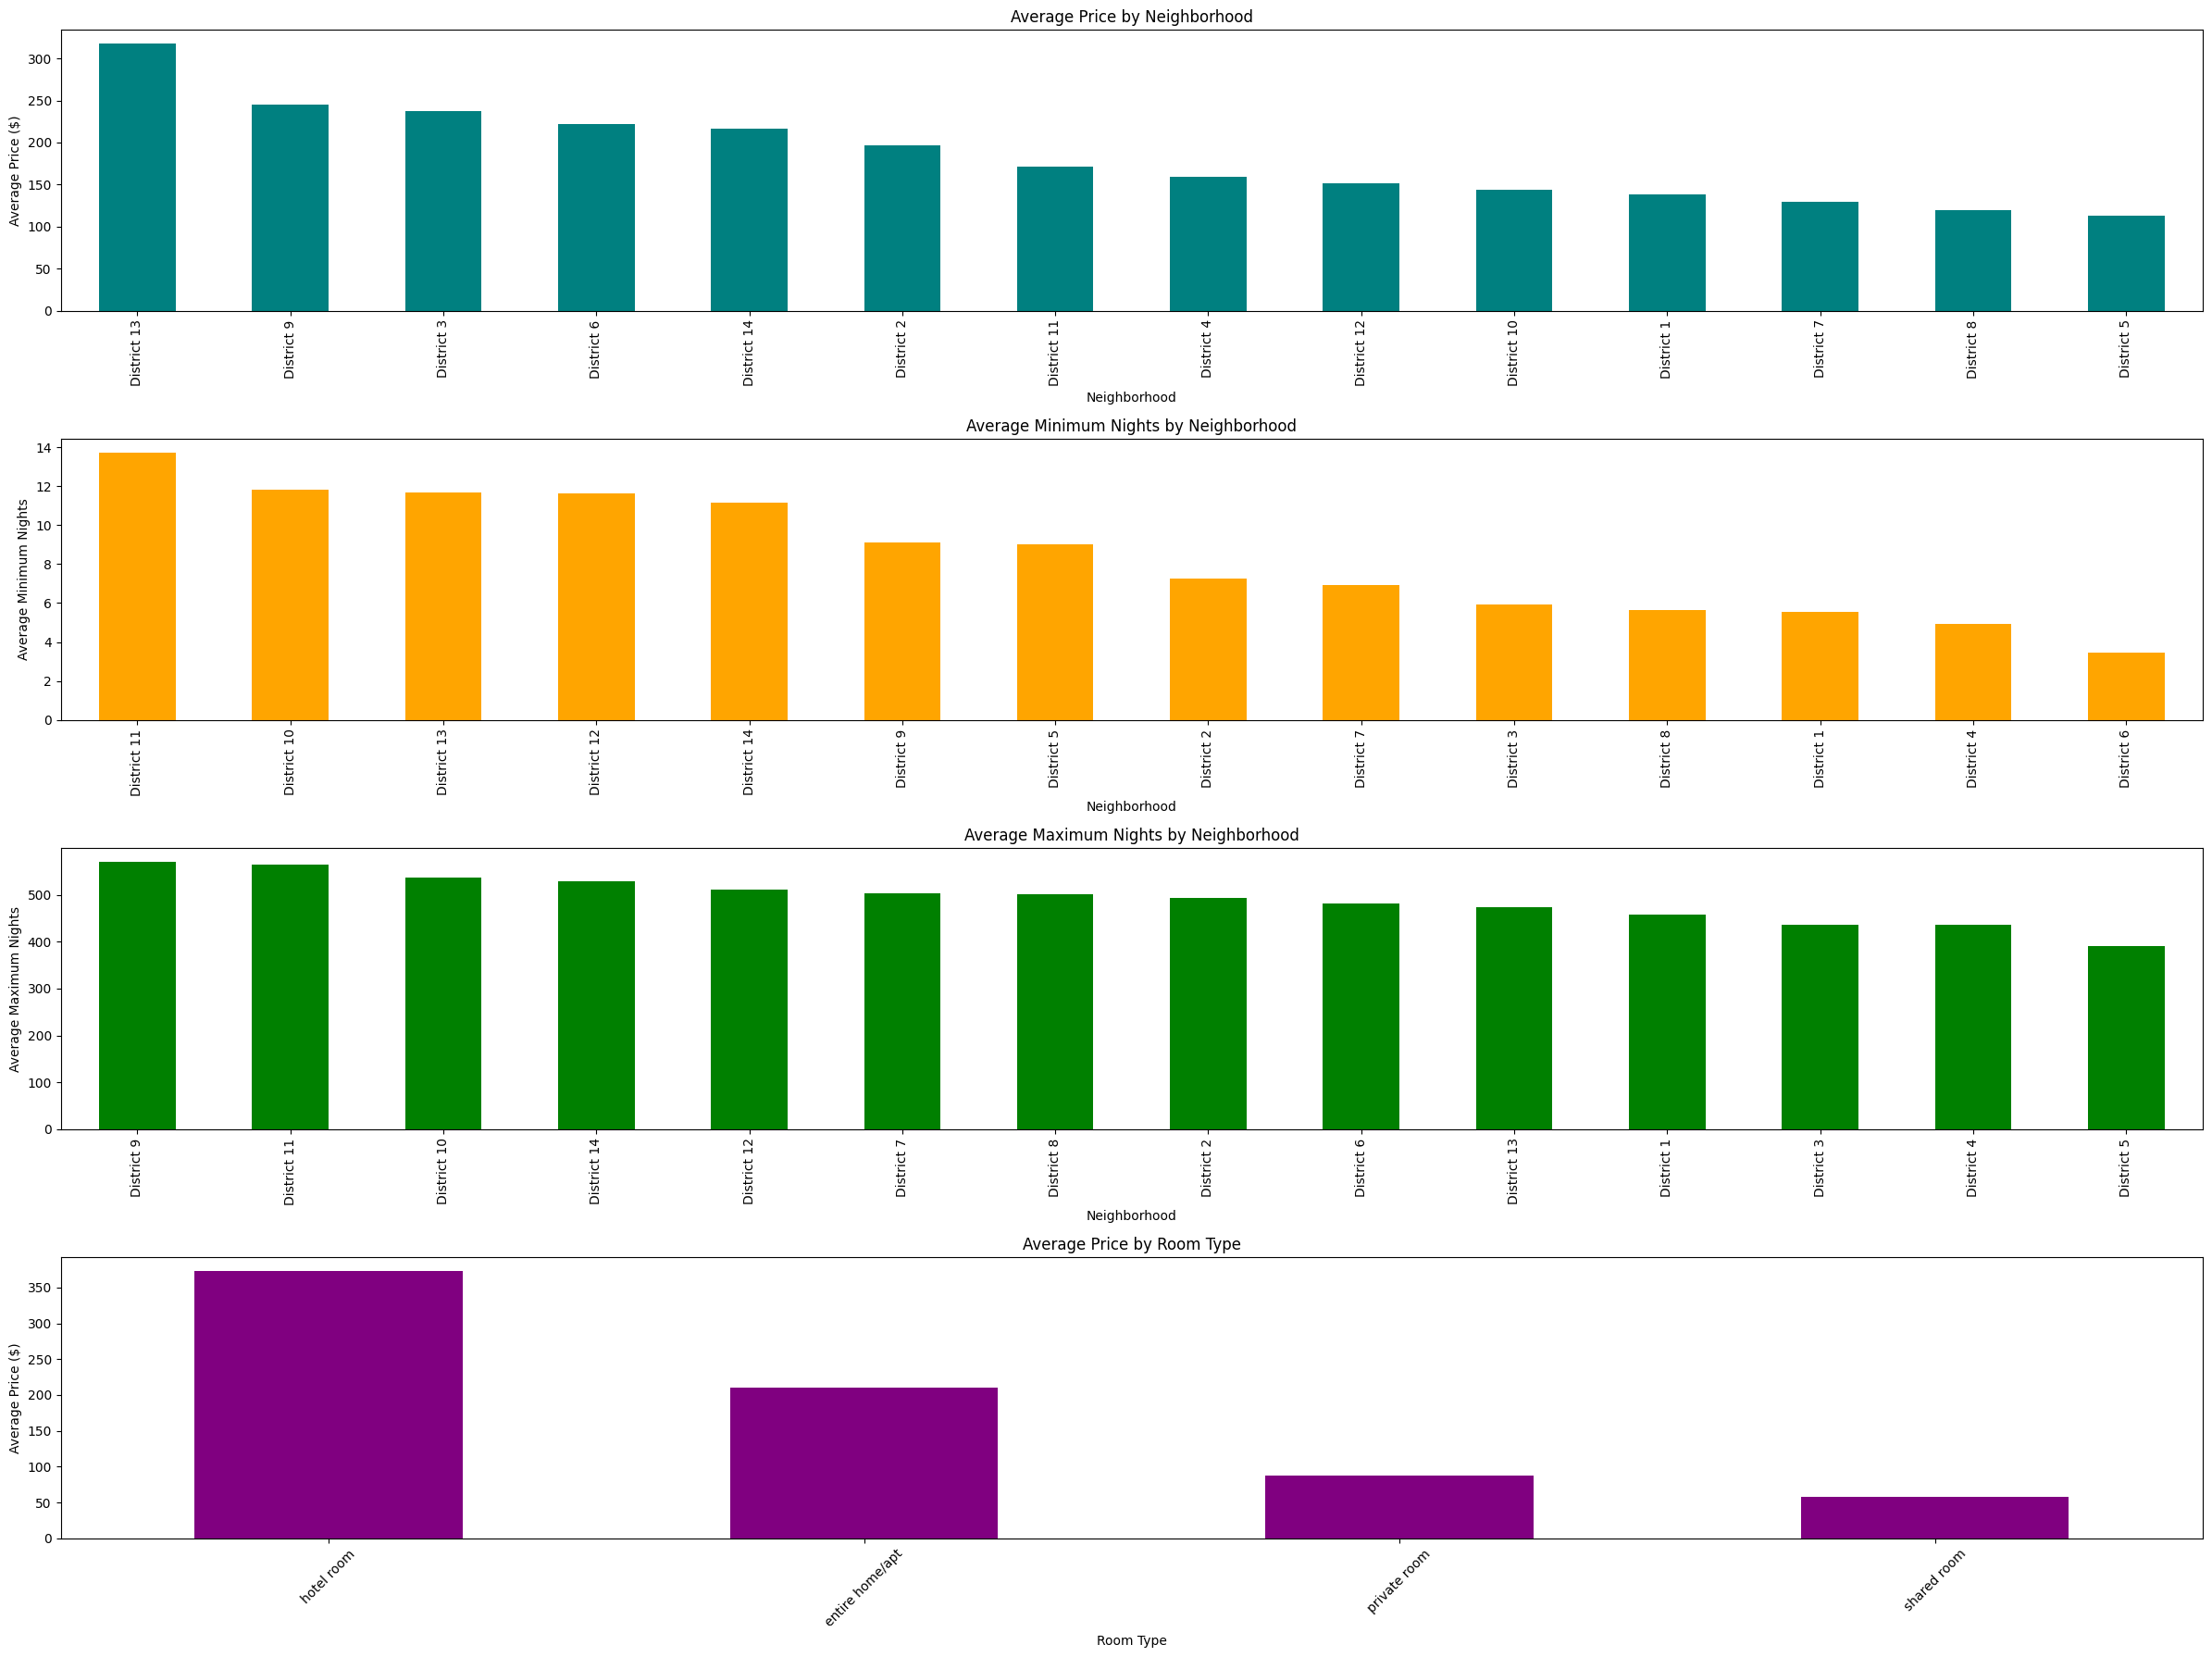

In [20]:
# Plotting price and minimum nights distributions across neighborhoods and room types
plt.figure(figsize=(24, 18))

# Average price by neighborhood
plt.subplot(4, 1, 1)
avg_price_neighbourhood.plot(kind='bar', color='teal')
plt.title('Average Price by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=90)

# Average minimum nights by neighborhood
plt.subplot(4, 1, 2)
avg_minimum_nights_neighbourhood.plot(kind='bar', color='orange')
plt.title('Average Minimum Nights by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Minimum Nights')
plt.xticks(rotation=90)

# Average maximum nights by neighborhood
plt.subplot(4, 1, 3)
avg_maximum_nights_neighbourhood.plot(kind='bar', color='green')
plt.title('Average Maximum Nights by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Maximum Nights')
plt.xticks(rotation=90)

# Average price by room type
plt.subplot(4, 1, 4)
avg_price_room_type.plot(kind='bar', color='purple')
plt.title('Average Price by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()



<Figure size 1600x800 with 0 Axes>

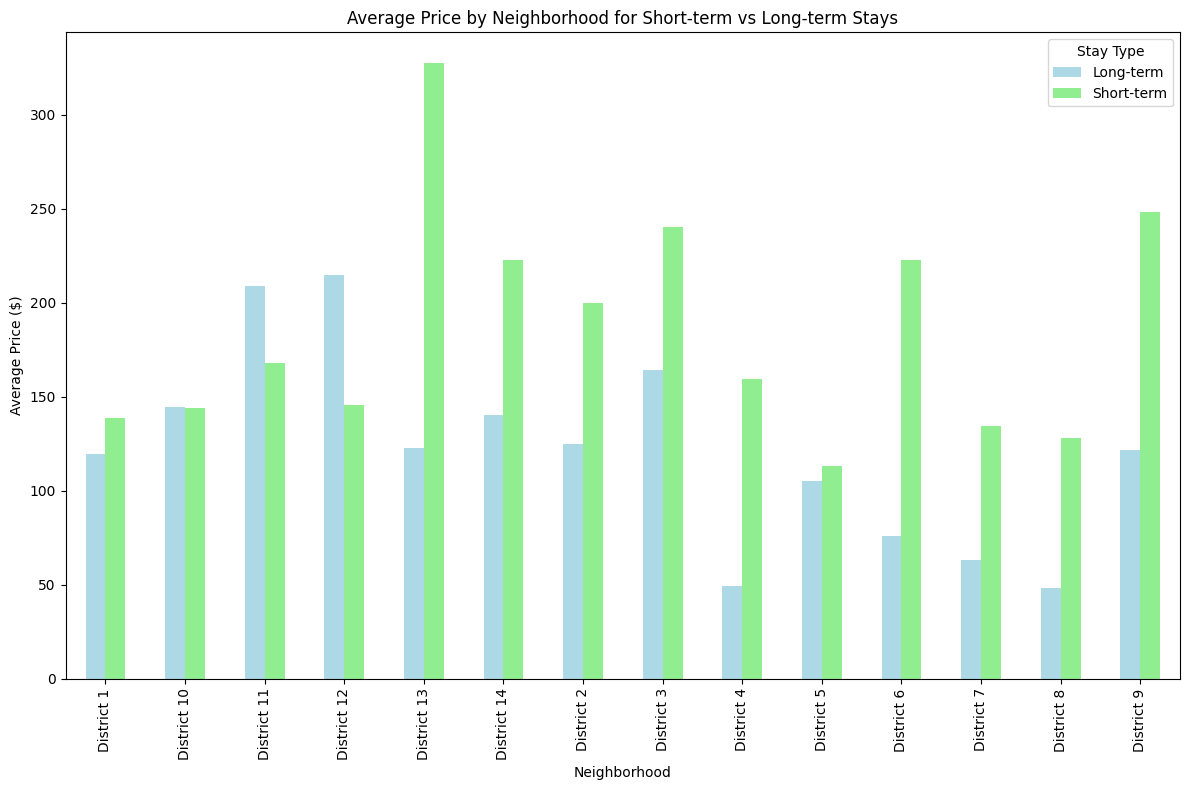

<Figure size 800x600 with 0 Axes>

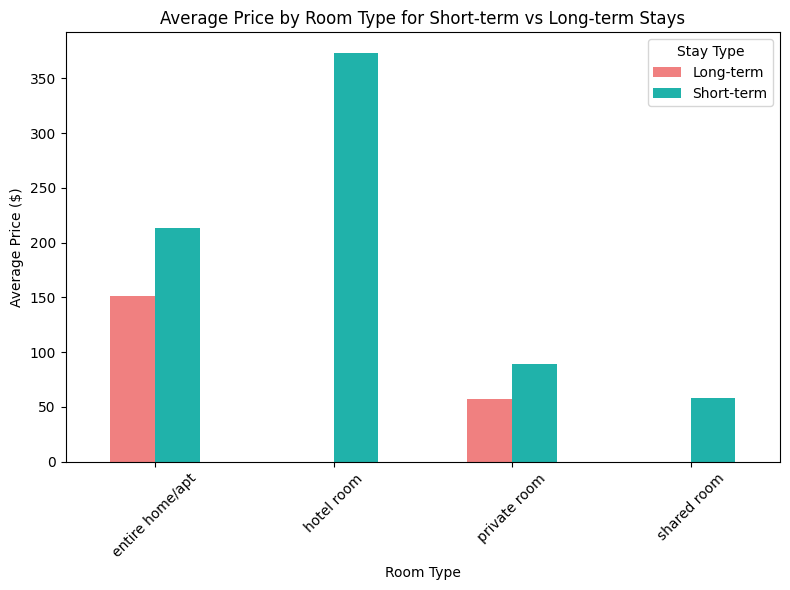

In [21]:
# Plotting average price by neighborhood for short-term and long-term stays
plt.figure(figsize=(16, 8))

# Average price by neighborhood for short-term and long-term stays
avg_price_neighbourhood_stay_type.plot(kind='bar', stacked=False, color=['lightblue', 'lightgreen'], figsize=(12, 8))
plt.title('Average Price by Neighborhood for Short-term vs Long-term Stays')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=90)
plt.legend(title='Stay Type')

plt.tight_layout()
plt.show()

# Plotting average price by room type for short-term and long-term stays
plt.figure(figsize=(8, 6))

# Average price by room type for short-term and long-term stays
avg_price_room_type_stay_type.plot(kind='bar', stacked=False, color=['lightcoral', 'lightseagreen'], figsize=(8, 6))
plt.title('Average Price by Room Type for Short-term vs Long-term Stays')
plt.xlabel('Room Type')
plt.ylabel('Average Price ($)')
plt.xticks(rotation=45)
plt.legend(title='Stay Type')

plt.tight_layout()
plt.show()

# 5. Neighborhood Comparison

Compare the average review_scores_rating across different neighborhoods. Determine if certain neighborhoods have consistently higher ratings, which could indicate better or worse guest experiences.

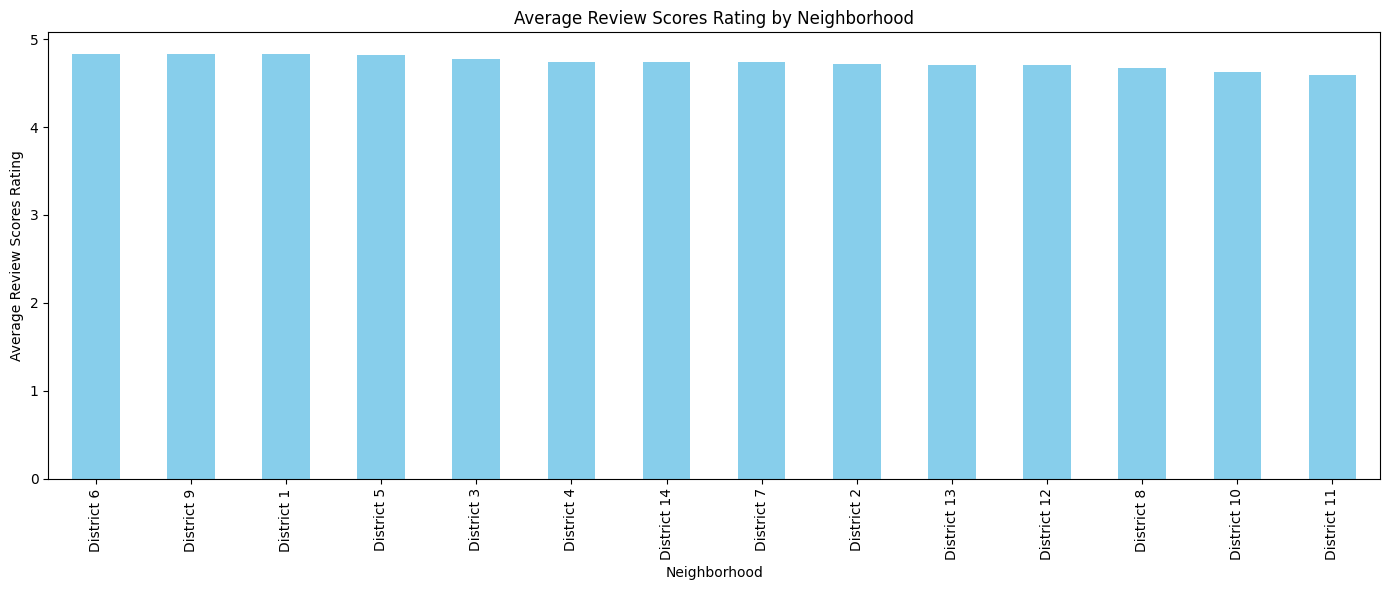

Average Review Scores Rating by Neighborhood:
neighbourhood_cleansed
District 6     4.836387
District 9     4.833133
District 1     4.827367
District 5     4.820833
District 3     4.778667
District 4     4.746033
District 14    4.735643
District 7     4.735301
District 2     4.717637
District 13    4.703838
District 12    4.702500
District 8     4.669808
District 10    4.625119
District 11    4.591928
Name: review_scores_rating, dtype: float64


In [22]:
import pandas as pd
import matplotlib.pyplot as plt


# Calculating average review_scores_rating per neighborhood
avg_rating_neighbourhood = listings.groupby('neighbourhood_cleansed')['review_scores_rating'].mean().dropna().sort_values(ascending=False)

# Plotting the average review_scores_rating across neighborhoods
plt.figure(figsize=(14, 6))
avg_rating_neighbourhood.plot(kind='bar', color='skyblue')
plt.title('Average Review Scores Rating by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Review Scores Rating')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Display the average review scores rating per neighborhood
print("Average Review Scores Rating by Neighborhood:")
print(avg_rating_neighbourhood)

# 6. Outlier Detection

Identify outliers in the dataset, particularly in price, minimum_nights, and review_scores_rating.

# Detecting outliers using IQR

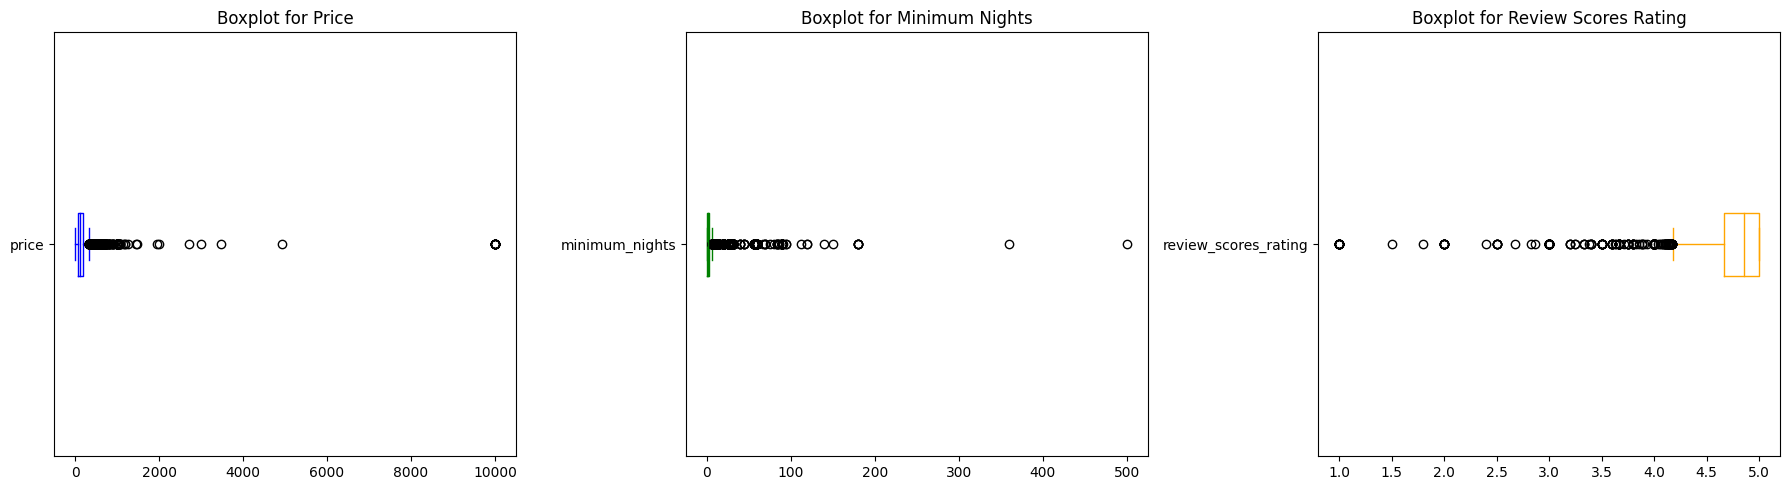

Number of price outliers: 355
      price
11    403.0
37    886.0
49    333.0
50    417.0
52    475.0
...     ...
4966  699.0
4981  552.0
4982  560.0
5017  385.0
5022  451.0

[355 rows x 1 columns]

Number of minimum nights outliers: 800
      minimum_nights
0                 30
1                 30
2                 30
3                 14
4                 30
...              ...
4637              30
4643              30
4855              30
4964              28
4966              30

[800 rows x 1 columns]

Number of review scores rating outliers: 272
      review_scores_rating
43                    3.60
231                   4.00
240                   4.07
284                   4.16
381                   4.00
...                    ...
4980                  3.80
4990                  3.00
5025                  1.00
5034                  3.67
5136                  4.00

[272 rows x 1 columns]

Total number of outliers detected: 1312
                       id                          

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming listings_1 is your original DataFrame
# List of columns to check for outliers
outlier_columns = ['price', 'minimum_nights', 'review_scores_rating']

# Function to detect outliers using IQR
def detect_outliers_iqr(listings, column):
    Q1 = listings[column].quantile(0.25)
    Q3 = listings[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = listings[(listings[column] < lower_bound) | (listings[column] > upper_bound)]
    return outliers

# Detecting outliers for each column and storing them in separate DataFrames
outliers_price = detect_outliers_iqr(listings_1, 'price')
outliers_minimum_nights = detect_outliers_iqr(listings_1, 'minimum_nights')
outliers_review_scores = detect_outliers_iqr(listings_1, 'review_scores_rating')

# Combine all outliers into one DataFrame
all_outliers = pd.concat([outliers_price, outliers_minimum_nights, outliers_review_scores]).drop_duplicates()

# Create a DataFrame without outliers
listings_no_outliers_IQR = listings_1[~listings_1.index.isin(all_outliers.index)]

# Visualizing outliers with boxplots
plt.figure(figsize=(18, 5))

# Boxplot for price
plt.subplot(1, 3, 1)
listings_1['price'].plot(kind='box', vert=False, color='blue')
plt.title('Boxplot for Price')

# Boxplot for minimum nights
plt.subplot(1, 3, 2)
listings_1['minimum_nights'].plot(kind='box', vert=False, color='green')
plt.title('Boxplot for Minimum Nights')

# Boxplot for review scores rating
plt.subplot(1, 3, 3)
listings_1['review_scores_rating'].plot(kind='box', vert=False, color='orange')
plt.title('Boxplot for Review Scores Rating')

plt.tight_layout()
plt.show()

# Display the number of outliers
print(f"Number of price outliers: {len(outliers_price)}")
print(outliers_price[['price']])

print(f"\nNumber of minimum nights outliers: {len(outliers_minimum_nights)}")
print(outliers_minimum_nights[['minimum_nights']])

print(f"\nNumber of review scores rating outliers: {len(outliers_review_scores)}")
print(outliers_review_scores[['review_scores_rating']])

# Display the number of total outliers and save to separate DataFrame
print(f"\nTotal number of outliers detected: {len(all_outliers)}")
print(all_outliers)

# The listings_no_outliers_IQR DataFrame now contains the data without outliers


# Outlier Detection using Z Score Technique  

Number of outliers per column:
price                   28
minimum_nights          85
review_scores_rating    92
dtype: int64


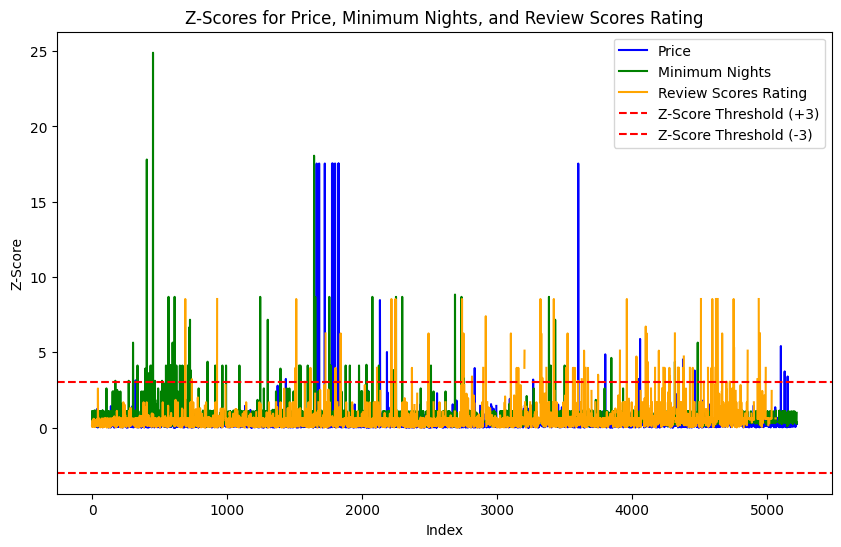

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def remove_outliers_z_score(dataframe, outlier_columns, threshold=3):
    """
    Remove outliers from the DataFrame using Z-Score method and store them in a new DataFrame.

    Parameters:
    dataframe (pd.DataFrame): The DataFrame containing the data.
    outlier_columns (list): List of columns to check for outliers.
    threshold (float): Z-score threshold for detecting outliers (default is 3).

    Returns:
    pd.DataFrame: DataFrame without outliers.
    pd.Series: Series with the number of outliers detected per column.
    """
    # Standardizing (z-scoring) the data for outlier detection
    z_scores = np.abs((dataframe[outlier_columns] - dataframe[outlier_columns].mean()) / dataframe[outlier_columns].std())

    # Detecting outliers with a z-score threshold
    outliers = z_scores > threshold

    # Number of outliers per column
    outliers_per_column = outliers.sum()

    # Displaying the number of outliers per column
    print("Number of outliers per column:")
    print(outliers_per_column)

    # Remove outliers from the original DataFrame
    dataframe_no_outliers = dataframe[~outliers.any(axis=1)]

    # Plotting the z-scores with colors for each property
    plt.figure(figsize=(10, 6))

    # Plot each property with a different color
    plt.plot(z_scores['price'], label='Price', color='blue')
    plt.plot(z_scores['minimum_nights'], label='Minimum Nights', color='green')
    plt.plot(z_scores['review_scores_rating'], label='Review Scores Rating', color='orange')

    # Add z-score threshold line at the specified threshold
    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Z-Score Threshold (+{threshold})')
    plt.axhline(y=-threshold, color='red', linestyle='--', label=f'Z-Score Threshold (-{threshold})')

    # Add labels and title
    plt.title('Z-Scores for Price, Minimum Nights, and Review Scores Rating')
    plt.xlabel('Index')
    plt.ylabel('Z-Score')

    # Add legend to show which color represents which property
    plt.legend()

    # Show the plot
    plt.show()

    return dataframe_no_outliers, outliers_per_column

listings_no_outliers_Z, outliers_per_column = remove_outliers_z_score(listings, outlier_columns)


Calculating summary statistics after dropping outliers according to IQR method

In [25]:
#IQR
display_summary_statistics(listings_no_outliers_IQR, numerical_features)

#Z Score
display_summary_statistics(listings_no_outliers_Z, numerical_features)

Summary Statistics:
             price  minimum_nights  maximum_nights  review_scores_rating
count  2917.000000     2917.000000     2917.000000           2917.000000
mean    126.555022        1.745629      511.372643              4.809266
std      65.824945        1.031276      395.715411              0.187629
min      21.000000        1.000000        3.000000              4.180000
25%      79.000000        1.000000      365.000000              4.710000
50%     109.000000        1.000000      365.000000              4.860000
75%     162.000000        2.000000     1125.000000              4.960000
max     326.000000        6.000000     1125.000000              5.000000
Summary Statistics:
             price  minimum_nights  maximum_nights  review_scores_rating
count  4823.000000     5016.000000     5016.000000           4224.000000
mean    162.007672        6.975080      505.496013              4.782704
std     156.657472       11.411683      381.962573              0.264248
min       6


Visualizing after outlier removal using IQR

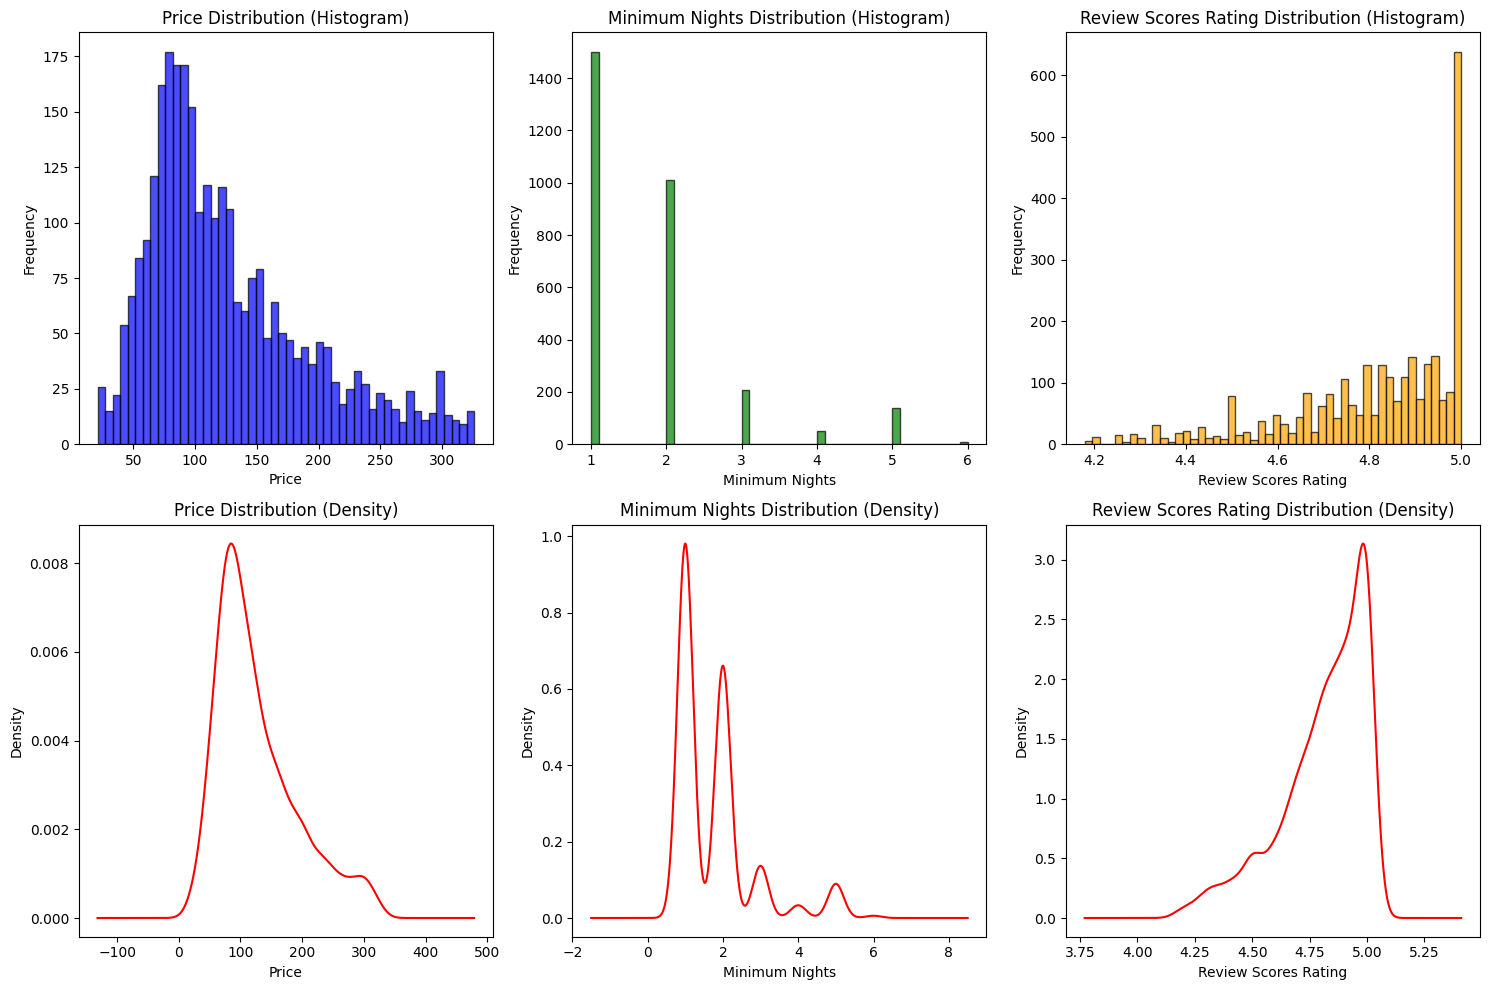

In [26]:
plot_numerical_distributions(listings_no_outliers_IQR)

Visualizing after outlier removal using Z Score

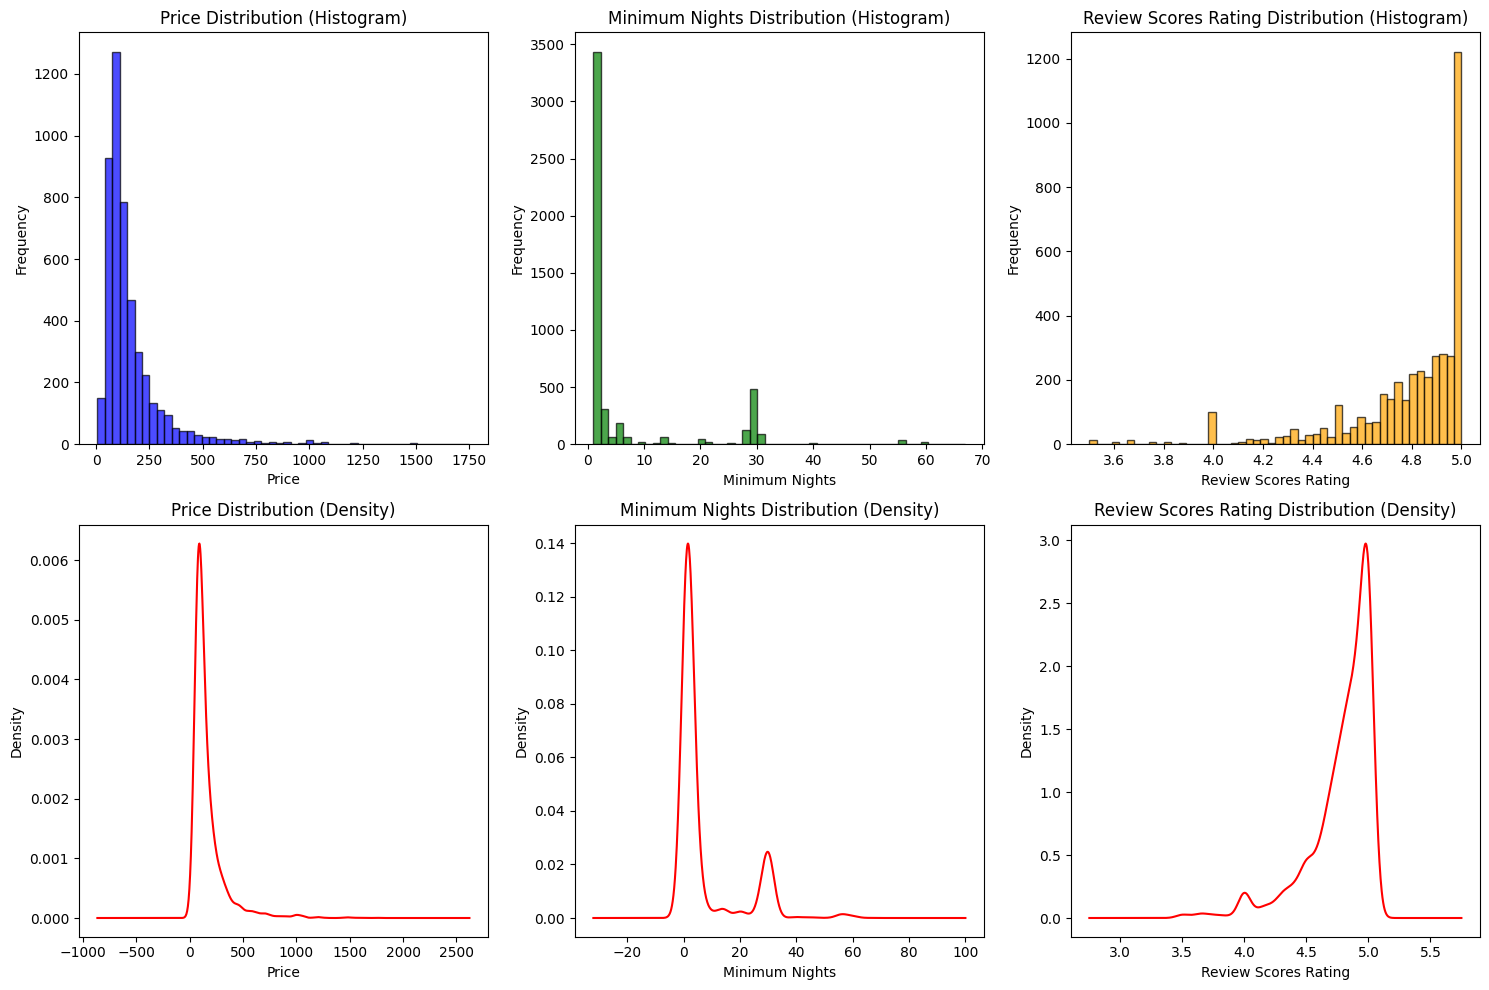

In [27]:
plot_numerical_distributions(listings_no_outliers_Z)

# Text Length

Create a new feature that measures the length of each review (number of words or characters). Determine if the length of a review correlates with its sentiment or the review scores.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   listing_id               4392 non-null   int64  
 1   avg_review_length_words  4392 non-null   float64
 2   review_scores_rating     4392 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 103.1 KB
None
Correlation between average review length and review score:
                         avg_review_length_words  review_scores_rating
avg_review_length_words                 1.000000             -0.280249
review_scores_rating                   -0.280249              1.000000


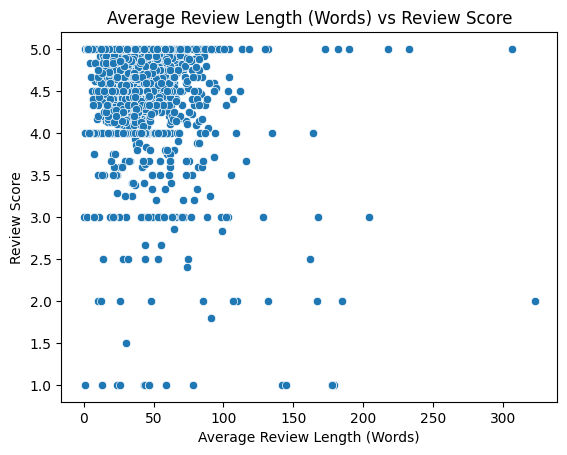

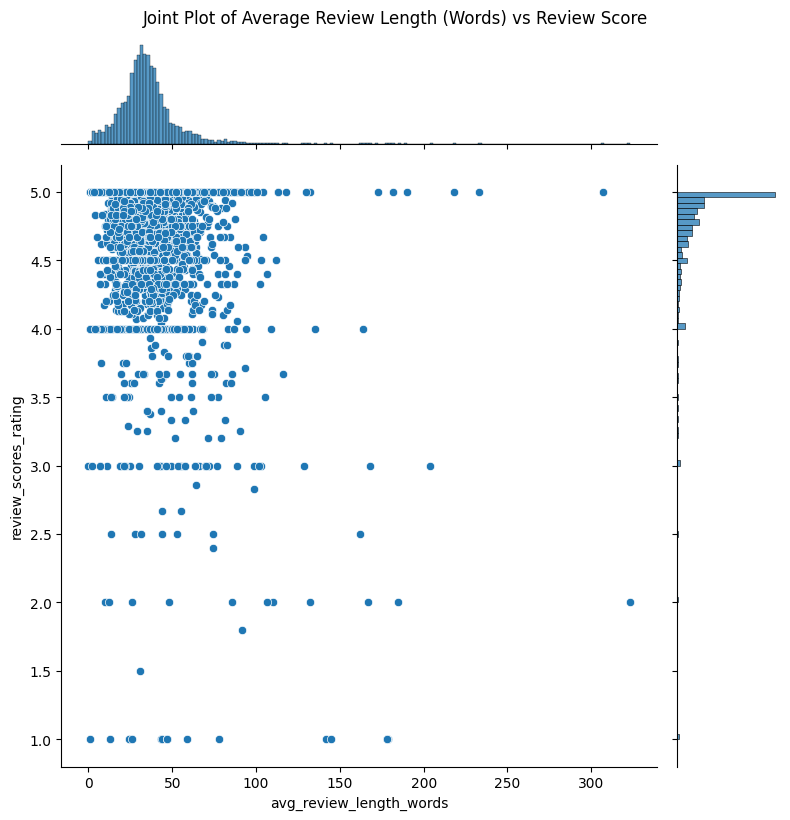

In [28]:
# Duplicate the 'id' column and name it 'listing_id' in listing dataset
listings['listing_id'] = listings['id']

# Fill missing values in the 'comments' column with an empty string
reviews['comments'] = reviews['comments'].fillna('')

# Define a function to clean HTML tags and special characters from the comments
def clean_text(text):
    # Ensure that the text is a string
    if not isinstance(text, str):
        return text

    # Remove HTML tags
    if '<' in text or '>' in text:  # Check if it contains HTML-like tags
        text = BeautifulSoup(text, "html.parser").get_text()

    # Remove special characters (keeping only letters, numbers, and basic punctuation)
    text = re.sub(r'[^A-Za-z0-9.,!?\'\s]', '', text)

    return text

# Apply the cleaning function to the 'comments' column
reviews['comments'] = reviews['comments'].apply(clean_text)

# Calculate the length of each review (both in words and characters)
reviews['review_length_words'] = reviews['comments'].apply(lambda x: len(str(x).split()))
reviews['review_length_chars'] = reviews['comments'].apply(lambda x: len(str(x)))

# Calculate the sentiment polarity of each review
reviews['sentiment'] = reviews['comments'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Group by 'listing_id' and calculate the average review length (in words) for each listing
avg_review_length = reviews.groupby('listing_id')['review_length_words'].mean().reset_index()
avg_review_length.columns = ['listing_id', 'avg_review_length_words']

# Merge the average review length with the cumulative review score from the 'listings' dataset
merged_data = avg_review_length.merge(listings[['listing_id', 'review_scores_rating']], on='listing_id', how='left')

# Drop any rows where review length or review score is missing
merged_data = merged_data.dropna(subset=['avg_review_length_words', 'review_scores_rating'])

# Display the merged data information
print(merged_data.info())

# Calculate the correlation between the average review length and the review score
correlation = merged_data[['avg_review_length_words', 'review_scores_rating']].corr()
print("Correlation between average review length and review score:")
print(correlation)

# Visualize the correlation using a scatter plot
sns.scatterplot(x='avg_review_length_words', y='review_scores_rating', data=merged_data)
plt.title('Average Review Length (Words) vs Review Score')
plt.xlabel('Average Review Length (Words)')
plt.ylabel('Review Score')
plt.show()

# Joint plot to show correlation between average review length and review score
sns.jointplot(x='avg_review_length_words', y='review_scores_rating', data=merged_data, kind='scatter', height=8)
plt.suptitle('Joint Plot of Average Review Length (Words) vs Review Score', y=1.02)
plt.show()


# Keyword Extraction

Identify and count the occurrence of specific keywords (e.g., "clean," "comfortable," "noisy") in the reviews. Generate new features based on the presence of these keywords, which might influence guest satisfaction

In [29]:
# Define positive and negative keywords
positive_keywords = ["great", "clean", "nice", "comfortable", "friendly", "spacious", "amazing", "fabulous"]
negative_keywords = ["uncomfortable", "noisy", "bad", "dirty", "terrible", "unpleasant", "poor"]

# Function to count keyword occurrences in a review, handling NaN values
def count_keywords(review, keywords):
    # Convert the review to a string to avoid errors
    review = str(review).lower()
    # Count occurrences of each keyword
    keyword_counts = {keyword: review.count(keyword) for keyword in keywords}

    return keyword_counts

# Apply the function and convert the result to a DataFrame for positive keywords
positive_keyword_counts_df = reviews["comments"].apply(lambda x: pd.Series(count_keywords(x, positive_keywords)))

# Add the 'positive_' prefix to the column names for positive keywords
positive_keyword_counts_df.columns = ['positive_' + col for col in positive_keyword_counts_df.columns]

# Join the positive keyword counts with the original DataFrame
reviews = reviews.join(positive_keyword_counts_df)

# Apply the function and convert the result to a DataFrame for negative keywords
negative_keyword_counts_df = reviews["comments"].apply(lambda x: pd.Series(count_keywords(x, negative_keywords)))

# Add the 'negative_' prefix to the column names for negative keywords
negative_keyword_counts_df.columns = ['negative_' + col for col in negative_keyword_counts_df.columns]

# Join the negative keyword counts with the original DataFrame
reviews = reviews.join(negative_keyword_counts_df)

# Aggregate keyword counts for each motel
aggregated_reviews = reviews.groupby('listing_id').sum().reset_index()

# Save aggregated reviews to a CSV file
aggregated_reviews.to_csv('aggregated_reviews.csv', index=False)

# List of columns to merge from 'aggregated_reviews'
columns_to_merge = [
    'listing_id', 'positive_great', 'positive_clean', 'positive_nice',
    'positive_comfortable', 'positive_friendly', 'positive_spacious',
    'positive_amazing', 'positive_fabulous', 'negative_uncomfortable',
    'negative_noisy', 'negative_bad', 'negative_dirty', 'negative_terrible',
    'negative_unpleasant', 'negative_poor'
]

# Select only the necessary columns from aggregated_reviews
aggregated_selected = aggregated_reviews[columns_to_merge]

# Merge using 'listing_id' from 'aggregated_reviews' and 'id' from 'listings'
listings = listings.merge(aggregated_selected, left_on='id', right_on='listing_id', how='left')

# Fill NaN values with 0 (in case some motels have no reviews)
listings = listings.fillna(0)

listings.to_csv('listings_with_keywords.csv', index=False)

# Select specific columns to display
columns_to_display = ['id', 'name', 'review_scores_rating'] + [f'positive_{kw}' for kw in positive_keywords] + [f'negative_{kw}' for kw in negative_keywords]
result = listings[columns_to_display]

# Debugging: Print the final result DataFrame
print("Final result DataFrame:")
print(result.head())

# Save the result to a CSV file
result.to_csv('result_keywords.csv', index=False)


Final result DataFrame:
       id                                              name  \
0   61878                     MODERN LIVING AND FURNISHINGS   
1  270936  1BR 1BA Oaklawn Condo Close to Downtown & Uptown   
2  795703          Amazing location walk to Downtown Dallas   
3  826118                     Far North Dallas -- Blue Room   
4  826201                     Far North Dallas -- Gray Room   

   review_scores_rating  positive_great  positive_clean  positive_nice  \
0                  4.70            42.0            19.0           19.0   
1                  4.93            35.0            19.0           12.0   
2                  4.85            58.0            21.0           27.0   
3                  4.85            17.0             2.0            3.0   
4                  4.75            13.0             8.0           11.0   

   positive_comfortable  positive_friendly  positive_spacious  \
0                   9.0                9.0                1.0   
1                   8.